In [1]:
import numpy as np
import torch
import pandas as pd
import odbo
import os

## Get initial experiment design

In [2]:
# Load dataset
random_seed = 0
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/GB1_2014_536944.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
shuffle_order = np.arange(len(Y_test))
np.random.shuffle(shuffle_order[1:])
name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
name = odbo.utils.code_to_array(name_pre)
del data_test, shuffle_order

if os.path.isfile('sele_experiment_GB1_2014.npy') == True:
    name_sele = np.load('sele_experiment_GB1_2014.npy')
    Y_train = np.load('sele_fitness_GB1_2014.npy')
    print('Selected initial experiments no. is ', len(Y_train))
else:
    # Let each site has 20 AA codes at least show up twice 
    sele_indices = odbo.initialization.initial_design(name, least_occurance=np.ones(name.shape[1]),verbose = True, update_method='correlate')
    # Initial experiments are selected to be name_sele with fitness of Y_sele
    name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
    print('Selected initial experiments no. is ', len(sele_indices))
    np.save('sele_experiment_GB1_2014.npy', name_sele)
    np.save('sele_fitness_GB1_2014.npy', Y_train)
print('Select max Y: ', Y_train.max(), 'True max Y:', Y_test.max())

Selected initial experiments no. is  138
Select max Y:  1.721 True max Y: 5.022


## Transform AA codes to average fitness feature 

In [3]:
# Using average measurement results as features
feature_model = odbo.featurization.FewChangeMeasurement(raw_vars=name_sele, Y=Y_train, method='Max', mode='correlate')
X_test, X_test_pca  = feature_model.transform(name)
X_train, X_train_pca = feature_model.transform(name_sele)

In [4]:
# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=16, n_iter=100, random_state=0)
# svd.fit(X_test)
# print(svd.singular_values_)
# print(svd.explained_variance_ratio_.sum())
print(feature_model._pca.explained_variance_)
print(feature_model._pca.explained_variance_ratio_)
print(feature_model._pca.explained_variance_ratio_.cumsum())


[0.37259527 0.23580226 0.21315109 0.16729523 0.15009659 0.14311979
 0.13477085 0.12481144]
[0.11306924 0.07155749 0.06468368 0.05076808 0.04554891 0.0434317
 0.0408981  0.03787577]
[0.11306924 0.18462673 0.24931041 0.30007849 0.34562739 0.38905909
 0.42995719 0.46783297]


## Adapt search space construction

In [6]:
# Find the adaptive search space model
threshold = Y_train[np.argsort(Y_train)[int(0.6*len(Y_train))]]
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error')
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)

[22:37:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Correct ratio: 55.236%
FN ratio: 23.791%
FP ratio: 20.973%


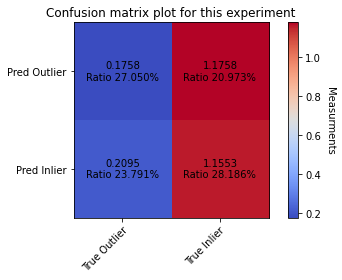

In [7]:
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test)))  

## BO for next best experiment

In [8]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
# Only search the space after prescreening
sele_id_test = list(np.where(pred_test_labels == 0)[0])
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
print('Prescreened search space size: ', len(sele_id_test), 'Entire dataset max: ', Y_test.max(), 'Select max ', Y_test_sele.max().item())

Prescreened search space size:  279087 Entire dataset max:  5.022 Select max  5.022


In [9]:
## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
batch_size = 1
gp_method='gp_regression'
failure_count,max_count = 0, 0
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), "Test max: ", Y_test_sele.max().detach().numpy())
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), name_sele_temp[-1])
    feature_model1 = odbo.featurization.MaxMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.AvgMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy())
    else:
        max_count = 0
    X_train_sele = torch.tensor(feature_model1.transform(X_train_sele))
    X_test_sele= torch.tensor(feature_model1.transform(X_test_sele))
    l = l + 1

#np.save('results/GB1_2014/GB1_2014_ODBO_BO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)

Iter:  0 Current Max:  1.721 Test max:  5.022


KeyboardInterrupt: 

## TurBO for next best experiment

In [ ]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
X_train_sele_pca = torch.tensor(X_train_pca)
X_test_sele_pca = torch.tensor(X_test_pca[sele_id_test, :])

# Run BO experiment with robust regression or directly GP
l, search_iter = 0, 50
gp_method='gp_regression'
tr_length = [3.2]
batch_size = 1
failure_count,max_count = 0,0
state = odbo.turbo.TurboState(dim=X_train_sele_pca.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, "Test max: ", Y_test_sele.max().detach().numpy())
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_train_sele_pca, Y=Y_train_sele, X_pending=X_test_sele_pca, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), name_sele_temp[-1])
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    feature_model1 = odbo.featurization.FewChangeMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), mode='correlate', method='Max')
    print(feature_model1._pca.explained_variance_ratio_.sum())
    if Y_train_sele[-batch_size:].detach().numpy().max() <= Y_train_sele[:-batch_size].max():
        failure_count = failure_count + 1
    else:
        failure_count = 0
    if failure_count >= 3 and max_count < 3:
        max_count = max_count + 1
        feature_model1 = odbo.featurization.FewChangeMeasurement(raw_vars=X_train_sele, Y=Y_train_sele.detach().numpy(), mode='correlate', method='Avg')
    else:
        max_count = 0
    X_train_sele, X_train_sele_pca = feature_model1.transform(X_train_sele)
    X_train_sele, X_train_sele_pca = torch.tensor(X_train_sele), torch.tensor(X_train_sele_pca)
    X_test_sele, X_test_sele_pca= torch.tensor(feature_model1.transform(X_test_sele))
    X_test_sele, X_test_sele_pca = torch.tensor(X_test_sele), torch.tensor(X_test_sele_pca)
    l = l + 1
np.save('results/GB1_2014/GB1_2014_ODBO_TuRBO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)


Iter:  0 Current Max:  1.721 TR length:  [3.2] Test max:  5.022
Newly added value:  [[1.273]] ['Q' 'Y' 'K' 'L' 'W' 'L' 'N' 'G' 'K' 'T' 'L' 'K' 'G' 'E' 'T' 'T' 'T' 'E'
 'A' 'V' 'D' 'A' 'A' 'T' 'A' 'E' 'K' 'V' 'F' 'K' 'Q' 'Y' 'A' 'N' 'D' 'N'
 'G' 'V' 'D' 'G' 'E' 'W' 'T' 'Y' 'D' 'D' 'A' 'H' 'K' 'T' 'F' 'T' 'V' 'T'
 'E']
